# RL Gaming AI

## Kihívások

## Evolúció

- Mocsar – Első próbálkozás, 2019 február
- Mocsar2 – Refaktorálás, osztályok, tud játszani, 2019 április
- RLCard – Rlcard.org keretrendszerbe költözés, 2019 december eleje
- RLCard2 – Első RL AI model futás, 2020 január
- RLCard3 – Rlcard.org git pull, refactor, PyTorch model, jelen

Hosszú folyamat eredménye az RLCard 3.

## 1. Elképzelés

### Válasszunk egyszerű esetet, és ott kezdjünk modellt építeni

Egyszerű eset, játsszanak amodellek kevesebb lappal.

### Random Agent

In [14]:
    def step(self, state) -> str:
        """ Predict the action given raw state. A naive rule.
        Choose a random action.

        Args:
            state (dict): Raw state from the game

        Returns:
            action (str): Predicted action
        """
        is_extract = state['is_extract']
        action_ids = get_action_ids(legal_actions=state['legal_actions'],
                                    is_extracted=is_extract)
        if len(action_ids) == 1:
            # Ha nincs miből választani
            ret = action_ids[0]
        elif action_ids[0] == 0:
            # ha lehet választani, akor nem passzol
            ret = int(np.random.choice(action_ids[1:]))
        else:
            ret = int(np.random.choice(action_ids))
        return action_to_ret(action=ret, is_extracted=is_extract)

Nem tűnik úgy, hogy különösebb tudása lenne a játékról, ennek ellenére kis kártyaszámra hatékony!

### Min Agent

In [15]:
    def step(self, state) :
        """ Predict the action given raw state. A naive rule.
        Choose the minimal action.

        Args:
            state (dict): Raw state from the game

        Returns:
            action (str): Predicted action
        """
        is_extract = state['is_extract']
        action_ids = get_action_ids(legal_actions=state['legal_actions'],
                                    is_extracted=is_extract)
        if len(action_ids) == 1:
            # Ha nincs miből választani
            return action_to_ret(action_ids[0], is_extract)
        elif action_ids[0] == 0:
            # ha lehet választani, akor nem passzol
            return action_to_ret(min(action_ids[1:]), is_extract)
        return action_to_ret(min(action_ids), is_extract)

Annak ellenére, hogy ennek sincs tudása a jáátékról, ez elég erős agent! Mivel az Action számozás jól sikerült. Implicit tudás.

### Min vs Random, CAS, kevés joker, adatok

In [16]:
import io
from urllib.request import urlopen
import pandas as pd

r = urlopen('https://github.com/cogitoergoread/rlcard3/raw/master/jupyter/data/CAS2_110_MMRR_500_20200405-113309.csv.gz')
df = pd.read_csv(io.BytesIO(r.read()), compression='gzip', sep=";")


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
def create_plots(df: pd.DataFrame, agentstr: str, title: str, is_violin: bool, filename: str):
    """
    Create nice figures from the played data
    :param title: Tilte of the figure
    :param df: DataFrame containing the logs of the games
    :param agentstr: Which type of data to display
    :param is_violin: Violin / line graph
    :param filename: filename to store the fihure
    """
    sns.set(rc={'figure.figsize':(12,7)})
    if is_violin:
        _ = sns.violinplot(x="cardnr", y="payoff", data=df[(df['agentstr'] == agentstr)], hue="agentid",
                           split=True).set_title(title)
    else:
        _ = sns.relplot(x="cardnr", y="payoff", kind="line", data=df[(df['agentstr'] == agentstr)], hue="agentid")
        plt.title(title)
    
    plt.show()


### Vizualizáció, Min vs Random, CAS, kevés joker, adatok

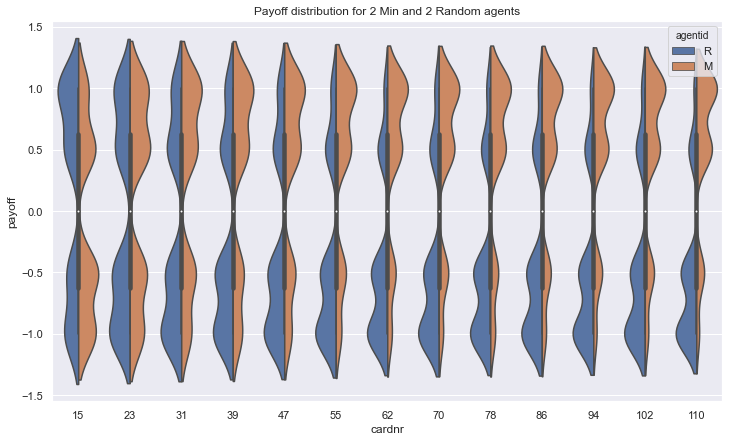

In [18]:
create_plots(df, 'MMRR', "Payoff distribution for 2 Min and 2 Random agents", True, "Ag2vs2V")

Látható, hogy 20-30 kártyára még elég erős a random agent. Nagyon számít a kártyák véletlen leosztása, és kicsit számít a játékerő.

## 2. Elképzelés, kis epoch szám

- Epoch: Egy teljes tanulási kör, minden adaton
- Episode: egy lejátszott kártyajáték információi

### Adat betöltés, performance.csv

In [19]:
import io
from urllib.request import urlopen
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

r1 = urlopen(
    'https://github.com/cogitoergoread/rlcard3/raw/master/jupyter/data/2020_04_07_DQN_Pytorch_Random_200k.csv.gz')
df1 = pd.read_csv(io.BytesIO(r1.read()), compression='gzip', sep=",")
df1['agent'] = 'R'
df = df1[['reward', 'episode', 'agent']]
df.head()

,reward,episode,agent
0,-0.174,0,R
1,-0.357,4000,R
2,-0.301,8000,R
3,0.452,12000,R
4,0.694,16000,R


### Vizualizáció, Mean payoff for DQN agent vs Random agents, episode

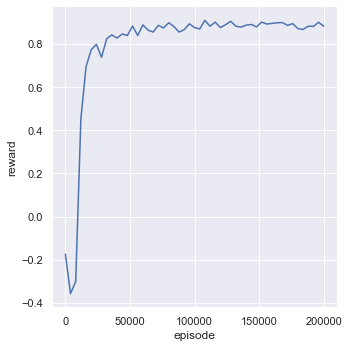

In [20]:
sns.set(rc={'figure.figsize':(12,7)})
_ = sns.relplot(x="episode", y="reward", kind="line", data=df )
plt.show()

## 3. Elképzelés, kitől érdemes tanulni

- NFSP: Önmaga ellen
- DQN: Random agent ellen
- DQN RA: Rule Agent (Min Agent) ellen

### Adat betöltés, 3 db performance.csv

In [4]:
import io
from urllib.request import urlopen
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

r1 = urlopen(
    'https://github.com/cogitoergoread/rlcard3/raw/master/jupyter/data/2020_04_07_DQN_Pytorch_Random_200k.csv.gz')
df1 = pd.read_csv(io.BytesIO(r1.read()), compression='gzip', sep=",")
df1['agent'] = 'R'

r2 = urlopen('https://github.com/cogitoergoread/rlcard3/raw/master/jupyter/data/2020_04_02_DQN_Pytorch_Min_200k.csv.gz')
df2 = pd.read_csv(io.BytesIO(r2.read()), compression='gzip', sep=",")
df2['agent'] = 'M'

r3 = urlopen('https://github.com/cogitoergoread/rlcard3/raw/master/jupyter/data/2020_04_10_NFSP_Pytorch_200k.csv.gz')
df3 = pd.read_csv(io.BytesIO(r3.read()), compression='gzip', sep=",")
df3['agent'] = 'N'


df = pd.concat([df1, df2, df3])

df = df[['reward', 'episode', 'agent']]
df.head()

,reward,episode,agent
0,-0.174,0,R
1,-0.357,4000,R
2,-0.301,8000,R
3,0.452,12000,R
4,0.694,16000,R


### Vizualizáció, Mean payoff for RLAI agent vs Random agents, episode

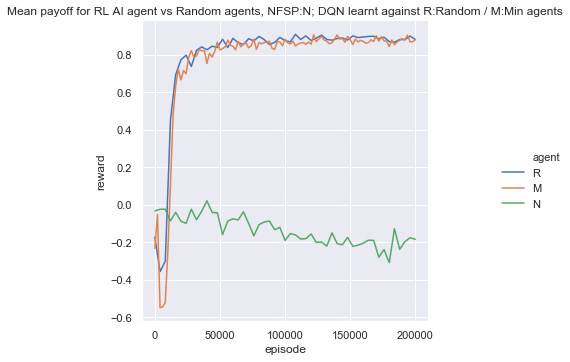

In [6]:
sns.set(rc={'figure.figsize':(12,7)})
title = "Mean payoff for RL AI agent vs Random agents, NFSP:N; DQN learnt against R:Random / M:Min agents"
_ = sns.relplot(x="episode", y="reward", kind="line", data=df , hue="agent")
plt.title(title)
plt.show()

NFSP Nem sikeres a tanulásban.

DQN érdekes módon pont annyira lehet random agenttől is tanulni, mint okosabb agenttől.

## Model méretek, CAS - RAS

RLCard 2020.02.10-ig TensorFlow 1.15 natív kódot tartalmazott.

Itt a modelle mentése - visszatöltése problémás.

Másrészt az elmentett modellek mérete kezelhetetlenül nagy.

Ráadásul nem lehet pontosan visszatölteni a modelleket eltérő architektúrán (Linux -> Windows)

### TensorFLow 1.15 model méretek

```
tar tvfj mocsar_nfsp_35_10k-2.tar.bz2
drwxr-xr-x muszi/Domain Users 0 2020-02-18 12:31 examples/experiments/mocsar_nfsp_result/
...
-rw-r--r-- muszi/Domain Users 1086160996 2020-02-19 00:03 examples/models/mocsar/model.data-00000-of-00001
```

```
-rw-r--r-- muszi/Domain Users 59326484 2020-03-01 17:34 examples/models/mocsar/model.data-00000-of-00001

```


|Model|Byte|Human|
|--|--|--|
|NFSP| 1 086 160 996|1 G|
|DQN| 59 326 484| 59 M|

### Túl nagy Action álllapottér

RLCard.org Paper: https://arxiv.org/pdf/1910.04376.pdf

 Speciﬁcally, they only achieve minor improvements during the learning process on UNO, Mahjong and Dou Dizhu. These games are challenging due to their **large state/action space** and sparse reward. We believe there is a lot of room for improvement. More efforts are needed to study how we can stably train reinforcement learning agents in these large environments. 

State állapot teret nem lehet csökkenteni. Action állapot teret azonban igen!

### CAS: Complex Action Space

In [ ]:
def tuple_to_actionm(nr_cards: int, rank: int, nr_jokers: int) -> int:
    """
    Converts a tuple of possibel action to int
    :param nr_cards: Number of cards played
    :param rank: Rank of the main card (Értekek)
    :param nr_jokers: Number of additional jokers
    :return: Joined 4 bit values
    """
    if rank == Ertekek.CO:
        # Joker esetén korrigál, azt másképp képezzük le
        return 256 * (nr_cards - 1) + 16 * rank + nr_cards
    return 256 * nr_jokers + 16 * rank + nr_cards

Ez 4096 elemű állapottér.

Tartalmaz számtalan - a játék szempontjából - nem 'logikus' akciót. Pl.

- 3 db 7est enged ütni 1 8-as + két jokerrel, holott van 3 8-as a kézben.

### RAS: Reduced Action Space

Csökkenteni kell az állapotok számát, hogy az RL modellek egyszerűbbek lehessenek.

In [ ]:
@unique
class Action(IntEnum):
    """
    Action definíciók
    """
    PS = 0  # Pass
    M2 = 1  # minden kettes, ha nem Joker
    M3 = 2  # Minden 3-as, ill 3-as felülütve
    M4 = 3
 ....
    MA = 13
    MO = 14  # Jokerrel felülütve, ill. minden joker
    J2 = 15  # Minden kettes az összes jokerrel
    J3 = 16
...
    JK = 26
    JA = 27  # Minden Ász és össze joker
    O2 = 28  # Egy darab 2, ha nincs Jokerre mapaelve
    O3 = 29  # Egy db hármas
    O4 = 30
 ...
    OK = 39
    OA = 40  # Egy Db Ász


### RAS hatása

Ez egy másik mocsár játék. Más szabályokkal.

Kezdéskor:
 - vagy egy lappal lehet kezdeni, 
 - vagy minden azonos értékű lappal, 
 - vagy minden azonos értékűvel + összes joker
 
Nem lehet 
 - kevesebb lappal kezdeni, 
 - nem nem összes jokerrel kezdeni
 
Mellékhatás, a RAS Min agent erősebb, mint a CAS Min agent. Kb mint CAS MinPlus agent.

### TensorFlow 1.15 model, RAS

```
tar tvfj RAS_50k-model-nfsp.tar.bz2
drwxr-xr-x muszi/Domain Users   0 2020-03-23 00:06 examples/models/mocsar_nfsp/
-rw-r--r-- muszi/Domain Users 786610036 2020-03-23 00:06 examples/models/mocsar_nfsp/model.data-00000-of-00001
```

```
tar tvfj RAS_50k-model-dqn-ra.tar.bz2 
drwxr-xr-x muszi/Domain Users  0 2020-03-24 10:27 examples/models/mocsar_dqn_ra/
-rw-r--r-- muszi/Domain Users 11465708 2020-03-24 10:27 examples/models/mocsar_dqn_ra/model.data-00000-of-00001
```

|Model|Byte|Human|
|--|--|--|
|NFSP| 786 610 036|786 M|
|DQN| 11 465 708| 11 M|

### Pytorch model, RAS, RLCard3

Szerencsére 2020.03.24 körül GitHub állapotban már volt Pytorch implemetnáció.

```
tar tvfz 2020_04_10_NFSP_Pytorch_200k_model.tar.gz 
drwxr-xr-x muszi/Domain Users 0 2020-04-07 19:46 examples/models/mocsar_nfsp_pytorch/
-rw-r--r-- muszi/Domain Users 23028012 2020-04-10 02:52 examples/models/mocsar_nfsp_pytorch/model.pth
```

```
 tar tvfj 2020_04_07_DQN_Pytorch_Random_200k_model.tar.gz
drwxr-xr-x muszi/Domain Users 0 2020-04-07 10:34 examples/models/mocsar_dqn_ra_pytorch/
-rw-r--r-- muszi/Domain Users 3837738 2020-04-07 10:34 examples/models/mocsar_dqn_ra_pytorch/model.pth
```

|Model|Byte|Human|
|--|--|--|
|NFSP| 230 280 126|230 M|
|DQN| 3 837 738 | 4 M|

Sajnos a Pytorch-ot nem sikerült Windows alatt működésre bírnom. Csak a szerveren futnak a tanított modellek.

## PyCharm fejlesztés, RLCard érdekességek

### Tesztek

In [ ]:
@pytest.mark.parametrize('cards, action, nr_cards, idxlist', [
    pytest.param([Card('H2'), Card('C2')], 'M2', 1, [0], id="Idx Kor 2*2; 1"),
    pytest.param([Card('H2'), Card('C2'), Card('C3')], 'M2', 2, [0, 1], id="Idx Kor 2*2, 3; 2"),
    pytest.param([Card('C3'), Card('H2')], 'M2', 1, [1], id="Idx Kor 3,2; 1"),
    pytest.param([Card('H7'), Card('**'), Card('H0'), Card('**')], 'M0', 1, [2], id="Idx Kor 7,0 2 Jok; 1"),
    pytest.param([Card('H7'), Card('**'), Card('H0'), Card('**')], 'M0', 2, [1, 2], id="Idx Kor 7,0 2 Jok; 2"),
    pytest.param([Card('H7'), Card('**'), Card('H0'), Card('**')], 'M0', 3, [1, 2, 3], id="Idx Kor 7,0 2 Jok; 3"),
    pytest.param([Card('♠K'), Card('♣K'), Card('♣2'), Card('♡A')], 'MK', 2, [0, 1], id="Kar 22KA, MK")
])
def test_get_cardidx_indeces(cards, action, nr_cards, idxlist):
    retli = get_card_indeces(cards, Action(action).value, nr_cards)
    assert retli == idxlist


action_str_data = [pytest.param(ac.value, ac.name, id=ac.name) for ac in Action]


@pytest.mark.parametrize('action, strret', action_str_data)
def test_action_to_string(action, strret):
    retstr = action_to_string(action=action)
    assert retstr == strret


@pytest.mark.parametrize('action, strret', action_str_data)
def test_string_to_action(action, strret):
    retact = string_to_action(strret)
    assert retact == action


Nagyon hasznosa a paraméterezett tesztek, tömören le lehet írni a kívnt eredményt.

### Futási eredmény

```
Testing started at 6:55 ...
C:\Users\gombk\.conda\envs\rlcard\python.exe "C:\Program Files\JetBrains\PyCharm_Ana_2019_1_3\plugins\python\helpers\pycharm\_jb_pytest_runner.py" --target test_utils.py::test_get_cardidx_indeces
Launching pytest with arguments test_utils.py::test_get_cardidx_indeces in F:\muszi\AnaPy\rlcard3\tests\games\mocsar

============================= test session starts =============================
platform win32 -- Python 3.6.7, pytest-5.0.1, py-1.8.1, pluggy-0.12.0 -- C:\Users\gombk\.conda\envs\rlcard\python.exe
cachedir: .pytest_cache
rootdir: F:\muszi\AnaPy\rlcard3\tests\games\mocsar
plugins: steps-1.7.1
collecting ... collected 8 items

test_utils.py::test_get_cardidx_indeces[Idx Kor 2*2; 2] PASSED           [ 12%]
test_utils.py::test_get_cardidx_indeces[Idx Kor 2*2, 3; 2] PASSED        [ 25%]
test_utils.py::test_get_cardidx_indeces[Idx Kor 3,2; 1] PASSED           [ 37%]
test_utils.py::test_get_cardidx_indeces[Idx Kor 7,0 2 Jok; M1] PASSED    [ 50%]
test_utils.py::test_get_cardidx_indeces[Idx Kor 7,0 2 Jok; O1] PASSED    [ 62%]
test_utils.py::test_get_cardidx_indeces[Idx Kor 7,0 2 Jok; 2] PASSED     [ 75%]
test_utils.py::test_get_cardidx_indeces[Idx Kor 7,0 2 Jok; 3] PASSED     [ 87%]
test_utils.py::test_get_cardidx_indeces[Kar 22KA, MK] PASSED             [100%]

========================== 8 passed in 12.29 seconds ==========================

Process finished with exit code 0
```

Tesztek az RLCard2 -> RLCard 3 migrációnál voltak különösen hasznosak. Egy már jó kód állapotból könnyen át lehetett térni egy másik jó állapotba.

### GitHub környezet

https://github.com/cogitoergoread/rlcard3

Branchek:

```
git branch -a
* CAS
  RAS
  master
  remotes/origin/CAS
  remotes/origin/HEAD -> origin/master
  remotes/origin/RAS
  remotes/origin/master
```

```
git log --stat
commit 3d7975c4a3f57b779ed5b01c6b3deacde88a1a59 (HEAD -> master, origin/master)
Author: Varga GHupi Jozsef <31209755+cogitoergoread@users.noreply.github.com>
Date:   Fri Apr 10 06:43:42 2020 +0200

    Zaro II
    NFSP payoff

 jupyter/data/2020_04_10_NFSP_Pytorch_200k.csv.gz | Bin 0 -> 1096 bytes
 jupyter/rl-ai-zaro-varga-jozsef-2.ipynb          | 307 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---
 rlcard3/games/mocsar/action.py                   |  17 ++--
 3 files changed, 302 insertions(+), 22 deletions(-)
```

Minden változást érdemes verzió kezelőben menteni. Eltérő verziókat lehet kezelni a kódhalmatból.

### PyCharm IDE

- Nagyon más, mint egy Jupyter notebook
- Segít szintaktikusan helyes kódot írni
- Jelzi a hibákat
- Debugger
- Git integráció
- Kikényszeríti a szép kódot PEP-8

### Futtatás távoli szerveren

|PC|Processor|RAM|TF|
|--|--|--|--|
|Notebook|i7|16 G|CPU|
|Server|i9|64 G|GPU|

Módszertan:
- Fejlesztés lokális gépen, kis Episode szám
- Tanítás szerveren.
```
screen
cd gwork/rlcard3
activate rlcard
export PYTHONPATH=~/gwork/rlcard3/rlcard3
cd examples
python mocsar_ln_dqn_ra_pytorch.py
```

Futásidő, Episode 200 000:

|Algoritmus|Kezdete|Vége|Idő|
|---|--|--|--|
|NFSP, Pytorch|2020-04-07 19:50:44|2020-04-10 02:51:46|55 óra|
|DQN, Pytorch| 2020-04-02 06:15:54|2020-04-02 17:30:20|11 óra|